In [1]:
%reset -f
%matplotlib inline

import numpy as np
from scipy.special import legendre
import matplotlib.pyplot as plt
from scipy.integrate import odeint

This code solves the 'time since infection' model described in our recent report [arxiv link when available].

$\frac{dS}{dt} = -R_0S\int_{-1}^{1}\beta(s)I(t,s)ds$

$\frac{\partial I}{\partial t} + \frac{\partial I}{\partial s} = 0$

$I(t,-1) = -\frac{dS}{dt}$

This code also considers the generalization to age-structured models and allows for an arbitrary number of sub-classes to the infected population with arbitrary time-dependent probabilities for entering/leaving those sub-classes

In [2]:
#######################################
###                                 ###
###   Transmission Characteristics  ###
###                                 ###
#######################################

T = 15       #What's the longest time (in days) for which a person can be infectious?
Td = 5       #What's the doubling time (in days) when in the linear growth regime?
Tf = 150     #simulation end time

Nk = 10      #number of stages to the infected class [for predictor/correcter method]
             #time step is fixed at T/Nk

#Make a linear interpolating function to describe how infectious a person is as a function of time since infection
#Note 1:  at present, we assume the -shape- of beta(s) is the same for all age groups
#Note 2:  beta(s) is an averaged value of transmission per unit normal contact (arbitrary units)
         #People who self-isolate or quarrantine are represented as reducing beta instead of reducing contacts
tsi = np.array([0,   3,    5,   10,   T])   #time since infection (days)
beta =np.array([0,   0.5,  1,   .5,   0])   #mean infectiousness (arbitrary units)
#for more detail on beta(s) and its interpretation, please see our report, section 2.2


#######################################
###                                 ###
###   Population Characteristics    ###
###                                 ###
#######################################

M = 2                #Number of age groups to model
Ni = 10**6*np.ones(M)  #Number of people in each age group
Np = sum(Ni)         #total population size

#Contact Matrix with arbitrary time dependence.  If using 'Hybrid' method, update tswap accordingly
def Cij_dim(t):
    return np.array([[4,1],[1,2]])

#Initial condition
automate_IC = True #IC is chosen based on fastest growing linear mode

#######################################
###                                 ###
###    Infecteds Characteristics    ###
###         -Biological-            ###
###                                 ###
#######################################

#Define sub-classes of infecteds - optional
subclasses = ['Recovered', 'Hospitalized', 'Deceased'] #e.g. Recovered, Hospitalized, Deceased
Nc = len(subclasses)

#Describe the dynamics of how people move in and out of subclasses.  See section 2.2 of report
if Nc > 0:
    #define the probability of eventually having membership in one 
    pR = 0.99*np.ones(M);  #probability of eventually recovering for each age class
    pH = 0.05*np.ones(M);  #probability of needing hospitalization for each age class
    pD = 1-pR;             #probability of death for each age class
    
    #prepare for a linear interpolating function evaluated at times:
    tsi_sc  =  np.array([0,   3.,    6.,    9.,   12,    T])  #For convenience, we say that you reach your final state at time T
                                                              #if this is not OK, adjust previous section accordingly
    
    #probability density function (arbitrary units) for transferring to each of the defined subclasses at tsi_sc
    #once again, the 'shape' of these curves is assumed to be same for all age classes.
    phiR     = np.array([0,    0,    0.5,   3,     2,     0])  #rate of transferring to 'recovered' (arbitrary units)
    phiH_in  = np.array([0,    0,    1,     1,     0,     0])  #rate that people enter hospital     (arbitrary units)
    phiH_out = np.array([0,    0,    0,     1,     1,     0])  #rate that people enter hospital     (arbitrary units)
    phiD     = np.array([0,    0,    0,     1,     1,    .5])  #times at which a person dies        (arbitrary units)
    
    ##########################
    ##Processing User inputs##
    ##########################
    #combine hospital in/out to a single function for net change in hospitalized cases
    phiH = -phiH_out/np.trapz(phiH_out,tsi_sc) + \
             phiH_in/np.trapz(phiH_in, tsi_sc)
    
    #normalize all to one -- can then be rescaled by approprate pR, pH, pD, etc. at a later time
    phiR = phiR/np.trapz(phiR,   tsi_sc)
    #phiH = phiH/np.trapz(phiH_in,tsi_sc)
    phiD = phiD/np.trapz(phiD,   tsi_sc)
    
    #group them all together for later processing
    phi_alpha = np.array([phiR, phiH, phiD])
    p_alpha = np.array([pR, pH, pD])
    
#######################################
###                                 ###
###    Infecteds Characteristics    ###
###            -Social-             ###
###                                 ###
#######################################

Qclasses = ['Voluntary', 'Assigned']
TQ = 1.1*T   #how long does an 'assigned' quarantine last? [Must be longer than or equal to T if phiQA_out not modelled]

nQ = len(Qclasses) #Not currently set up to handle anything besides nQ = 2...

#describe how people move in and out of quarantine:
def pQV(t):  return 0.3*np.ones(M)    #time-dependent proportion of each age group that voluntarily quarantines
def pQA(t):  return 0.2*np.ones(M)    #time-dependent proportion of each age group assigned to quarantine.

#probability density function for the time since infection at which people move in/out of quarantine:
tsiQ     =  np.array([0,  2,  4,  6,  8,  10, 12,  T]) #We assume that all voluntary quarantines of infected people
                                                       #end by the time that person is no longer infectious
#Voluntary quarantines:
phiQV_in =  np.array([0, .1, .5, .8, .6,  .1,  0,  0]) #probability density for moving into vol. Quarantine
phiQV_out = np.array([0,  0,  0,  0, .1,  .3, .5, .5]) #probability density for moving out of vol Quarantine
                                                       #(arbitrary units)

#Assigned Quarantines:
phiQA_in =  np.array([0, .1, .5, .8, .6,  .1,  0,  0]) #probability density for moving into assigned Quarantine
                                                       #(arbitrary units)
#phiQA_out is just equal, opposite, and time-shifted to times > T.  Not worth tracking, better to back-calc exits.

##########################
##Processing User inputs##
##########################
phiQV = np.add(-phiQV_out/np.trapz(phiQV_out,tsiQ),phiQV_in/np.trapz(phiQV_in,tsiQ))
#transform this to a cumulative distribution function for the number presently in quarantine
PhiQV = np.zeros(len(tsiQ))
for i in range(len(tsiQ)-1):
    PhiQV[i+1] = PhiQV[i] + 1/2*(tsiQ[i+1] -tsiQ[i])*(phiQV[i+1] + phiQV[i])

phiQA = phiQA_in/np.trapz(phiQA_in,tsiQ)

#initial conditions for assigned quarantines:
Phi_QA_0 = np.zeros((Nk,M))
#[note this method only accounts for quarantines assigned AFTER starting point]

#define a separate contact matrix for quarantined:
def CijQ_dim(t):
    return np.array([[1,0],[0,.5]])

#######################################
#######################################
###                                 ###
###       End of user Inputs        ###
###                                 ###
#######################################
#######################################

#################################################################################################################
#################################################################################################################

#######################################
###                                 ###
###      Nondimensionalization      ###
###          and rescaling          ###
###                                 ###
#######################################

Nondimensional = False

if not Nondimensional:
    
    Tc = T/2 #rescaling of time, and tsi
             #population numbers scaled by Np
    
    #first step is to rescale beta to a value consistent with the given Td
    def rescale_beta(Cij,Ni,T,Td,tsi,beta):
        A = np.matmul(np.diag(Ni),Cij)
        A = np.matmul(A,np.diag(1/Ni))
        max_eig_A = np.max(np.real(np.linalg.eigvals(A)))
        sp = np.linspace(0,T,1000)
        lam = np.log(2)/Td;  #Growth rate
        rs = max_eig_A*np.trapz(np.exp(-lam*sp)*np.interp(sp,tsi,beta),sp)
        return beta/rs       #now beta has been rescaled to give the correct (dimensional) doubling time
    
    beta = rescale_beta(Cij_dim(0), Ni, T, Td, tsi, beta)
    
    #define a rescaled tsi
    s = np.linspace(-1,1,Nk)
    
    #next make sure that the initial condition is known
    def get_IC(ep):
        #Initial susceptible is the whole population
        S_0 = Ni
        
        #get contact matrix from frist time step
        Cij = Cij_dim(0)
        
        #get I_0 from linear stability analysis
        #find the fastest growing linear mode
        A = np.matmul(np.diag(Ni),Cij)
        A = np.matmul(A,np.diag(1/Ni))
        sp = np.linspace(0,T,1000)
        lam = np.log(2)/Td;
        A = A*np.trapz(np.exp(-lam*sp)*np.interp(sp,tsi,beta),sp)
        w, v = np.linalg.eig(-np.identity(M) + A)
        
        #now identify the largest eigenvalue/eigenvector...
        pos = np.where(w == np.amax(w))
        pos = pos[0][0]
        lam = T/Td*np.log(2)
        s = np.linspace(-1,1,Nk)
        I_0 = ep*np.abs(np.real(np.outer(np.exp(-lam*s),v[:,pos])))

        #just set Ic_0 to zero -- these numbers are too small to matter
        Ic_0 = np.zeros((Nc,M))

        return S_0, I_0, Ic_0

    if automate_IC:
        S_0, I_0, Ic_0 = get_IC(10**-3/T*Np)
        
    #rescale all population sizes
    Ni = Ni/Np
    I_0 = I_0/Np*Tc  #recall that this is a number density (number infected per unit tsi)
    S_0 = S_0/Np
    if Nc > 0:
        Ic_0 = Ic_0/Np*Tc
        
    #precompute Cij/Nj as a rescaled contact matrix:
    def Cij_t(t):
        return np.matmul(Cij_dim(t*Tc),np.diag(1/Ni))
    
    #nondimensionalize beta:
    beta = beta*Tc
    tsi = tsi/Tc - 1
    
    #rescale phi_alpha based on re-scaling of tsi:
    phi_alpha = phi_alpha*Tc
    tsi_sc = tsi_sc/Tc - 1
    
    if nQ > 0:
        tsiQ = tsiQ/Tc - 1
        TQ = TQ/Tc
        phiQA = phiQA*Tc
        phiQV = phiQV*Tc
        def pQV_t(t):
            return pQV(t*Tc)
        def pQA_t(t):
            return pQA(t*Tc)
        def CijQ_t(t):
            return np.matmul(CijQ_dim(t*Tc),np.diag(1/Ni))
    
    #rescale end time
    Tf = Tf/Tc
    
    #Now that's done.
    Nondimensional = 1
    
    #bundle all 'output' parameters together:
    params = [M, Nc, Nk, Tf, tsi, beta, tsi_sc, phi_alpha, p_alpha, Cij_t]
    Qparams = [tsiQ, TQ, PhiQV, phiQA, Phi_QA_0, pQV_t, pQA_t, CijQ_t]
    IC = [S_0, I_0, Ic_0]
        

In [3]:
def solve_Predictor_Corrector_Q(params, IC, Qparams = []):
    #unbundle parameters:
    M, Nc, Nk, Tf, tsi, beta, tsi_sc, phi_alpha, p_alpha, Cij_t = params
    S_0, I_0, Ic_0 = IC
    
    if len(Qparams) == 0:
        nQ = 0
    else:
        nQ = 2
        tsiQ, TQ, PhiQV, phiQA, Phi_QA_0, pQV_t, pQA_t, CijQ_t = Qparams

    #set up the discretization in s
    s = np.linspace(-1,1,Nk)
    h = 2/(Nk - 1)
    
    #find the timesteps
    nt = int(np.round(Tf/h)) + 1
    t = h*np.linspace(0,nt-1,nt)
    
    #weighted betas for numerical integration
    beta_n = h*np.interp(s,tsi,beta)
    beta_n[[0, Nk-1]] = beta_n[[0, Nk-1]]/2
    
    #weighted phi_alpha for numerical integration
    phi_alpha_n = np.zeros((Nc, Nk))
    for i in range(Nc):      
        phi_alpha_n[i,:] = h*np.interp(s,tsi_sc,phi_alpha[i,:])
        phi_alpha_n[i,[0,Nk-1]] = phi_alpha_n[i,[0,Nk-1]]/2

    #weights for generic trapezoid integration
    w = h*np.ones(Nk)
    w[[0, Nk-1]] = w[[0, Nk-1]]/2
    
    #initialize variables
    S = S_0 + 0
    I = I_0 + 0
    Ic = Ic_0 + 0
        
    #initialize output vectors:
    S_t = np.zeros((M, nt))
    I_t = np.zeros((M, nt))
    Ic_t = np.zeros((Nc,M,nt))
    
    #set their starting values:
    S_t[:,0] = S_0
    I_t[:,0] = np.matmul(w,I_0)
    Ic_t[:,:,0] = Ic_0

    #initialize a few variables
    dIc_dt_e = np.zeros((Nc,M))
    dIc_dt_i = np.zeros((Nc,M))
    
    #In case there is a quarantine class:
    if nQ > 0:
        #Voluntary quarantines
        Phi_QV_n = h*np.interp(s,tsiQ,PhiQV)

        #Assigned quarantines
        phi_QA_n = h*np.interp(s,tsiQ,phiQA)   #further processing needed
        Phi_QA_n = Phi_QA_0
        
        #initialize variables/lists
        IQV = np.matmul(w,np.outer(Phi_QV_n,pQV_t(0))*I_0)
        IQA = 0
        IQV_t = np.zeros((M,nt))
        IQA_t = np.zeros((M,nt))
        IQV_t[:,0] = IQV
        IQA_t[:,0] = IQA
        
    
    for i in (1 + np.arange(nt-1)):
        ######################
        # explicit time step #
        ######################
        
        if nQ == 0:
            dSdt_e = -np.matmul(np.matmul(np.diag(S),Cij_t(t[i])),np.matmul(beta_n,I))
        else:
            IQA = Phi_QA_n*I
            IQV = np.outer(Phi_QV_n,pQV(t[i-1]))*I
            IQ = IQA + IQV
            dSdt_e = -np.matmul(np.matmul(np.diag(S), Cij_t(t[i-1])),np.matmul(beta_n,I-IQ)) + \
                     -np.matmul(np.matmul(np.diag(S),CijQ_t(t[i-1])),np.matmul(beta_n,  IQ))
           
        Sp = S + h*dSdt_e
        
        for j in range(Nc):
            dIc_dt_e[j,:] = np.matmul(phi_alpha_n[j,:],I)*p_alpha[j,:]
        
                
        #update assigned quarantine profile:
        if nQ > 0:
            dPhi_QA_dt = 1/2*(np.outer(phi_QA_n[1:],      pQA_t(t[i-1])) +\
                              np.outer(phi_QA_n[:(Nk-1)], pQA_t(t[i-0])))
            dIQA_dt = 1/2*(np.outer(phi_QA_n[1:],      pQA_t(t[i-1]))*I[1:     ,:] +\
                           np.outer(phi_QA_n[:(Nk-1)], pQA_t(t[i-0]))*I[:(Nk-1),:])
            Phi_QA_n[1:,:] = Phi_QA_n[:(Nk-1),:] + h*dPhi_QA_dt
        
        #update infected profile
        I[1:Nk,:] = I[0:(Nk-1),:]
        I[0,:] = -dSdt_e
                                                        
        ##################
        #'implicit' step #
        ##################                                                
        
        if nQ == 0:
            dSdt_i= -np.matmul(np.matmul(np.diag(Sp),Cij_t(t[i])),np.matmul(beta_n,I))
        else:
            IQA = Phi_QA_n*I
            IQV = np.outer(Phi_QV_n,pQV(t[i]))*I
            IQ = IQA + IQV
            dSdt_i = -np.matmul(np.matmul(np.diag(Sp), Cij_t(t[i])),np.matmul(beta_n,I-IQ)) + \
                     -np.matmul(np.matmul(np.diag(Sp),CijQ_t(t[i])),np.matmul(beta_n,  IQ))

        S = S + h/2*(dSdt_e + dSdt_i)
        
        for j in range(Nc):
            dIc_dt_i[j,:] = np.matmul(phi_alpha_n[j,:],I)*p_alpha[j,:]
        
        Ic = Ic + h/2*(dIc_dt_e + dIc_dt_i)

        I[0,:] = -dSdt_i
        
        #remember this timestep
        S_t[:,i]     = S
        I_t[:,i]     = np.matmul(w,I)
        Ic_t[:,:, i] = Ic
        if nQ > 0:
            IQV_t[:,i]   = np.matmul(w,IQV)
            IQA_t[:,i]   = IQA_t[:,i-1] + h*np.sum(dIQA_dt,0)
    
    if nQ > 0:
        #back calculate the population currently under quarantine:
        tb = t[nt-1]; count = nt-1
        while (tb - h) > TQ:
            for i in range(M):
                IQA_t[i,count] += -np.interp(tb - TQ, t ,IQA_t[i,:])
            count += - 1
            tb += -h
        
        return t, S_t, I_t, Ic_t, IQV_t, IQA_t                      
    else:
        return t, S_t, I_t, Ic_t
#     else:
#         return t, S_t, I_t, Ic_t, [S, I, Ic]

(0, 17210.654926837145)

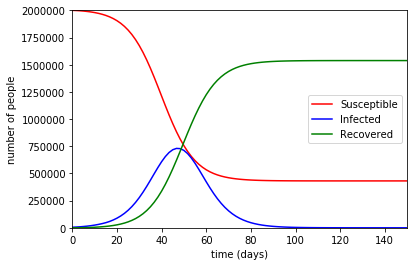

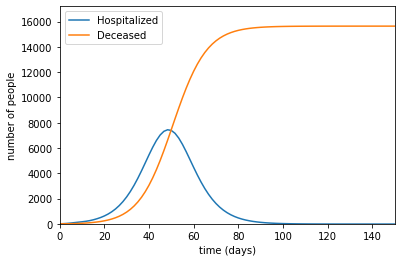

In [4]:
t, S_t, I_t, Ic_t, IQV_t, IQA_t = solve_Predictor_Corrector_Q(params, IC, Qparams) # 

#Standard SIR plot
plt.figure()    
plt.plot(t*Tc,Np*np.sum(S_t,0),'r', label = 'Susceptible')           #all susceptible
plt.plot(t*Tc,Np*np.sum(I_t,0),'b', label = 'Infected')              #all Infected
plt.plot(t*Tc,Np*np.sum(Ic_t[0,:,:],0),'g', label = subclasses[0])   #all recovered
plt.legend()
plt.xlabel('time (days)');       plt.xlim(0,Tf*Tc)
plt.ylabel('number of people');  plt.ylim(0,Np)

#Other subclasses of Infected:
plt.figure() 
for i in (1 + np.arange(Nc-1)):
    plt.plot(Tc*t,Np*np.sum(Ic_t[i,:,:],0), label = subclasses[i])
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('number of people')
plt.xlabel('time (days)');       plt.xlim(0,Tf*Tc)
plt.ylabel('number of people');  plt.ylim(0,1.1*np.amax(Np*np.sum(Ic_t[2,:,:],0)))



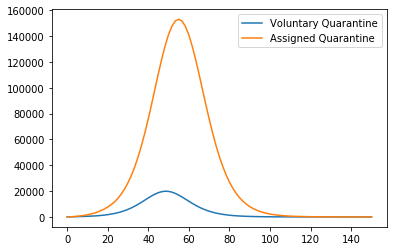

In [5]:
plt.figure()
plt.plot(t*Tc,Np*np.sum(IQV_t,0),label = 'Voluntary Quarantine')
plt.plot(t*Tc,Np*np.sum(IQA_t,0),label = 'Assigned Quarantine')
plt.legend()



16000.0